<a href="https://colab.research.google.com/github/YashChaudhary16/PyTorch/blob/main/02_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.datasets import make_circles
import pandas as pd

### Device Agnostic Code

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Data

In [3]:
n_samples = 1000

X, y = make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
# Make a dataframe of circles
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

In [6]:
circles[:10]

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


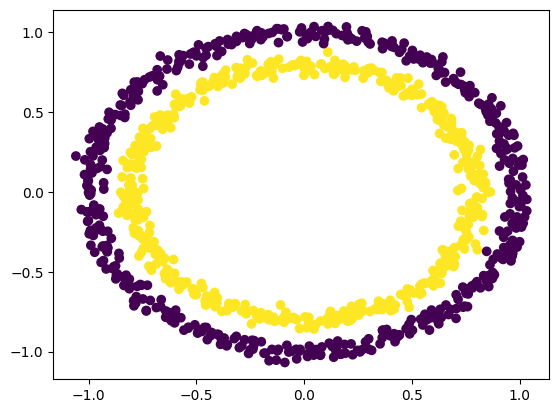

In [7]:
plt.scatter(x=circles['X1'],
            y=circles['X2'],
            c=y)

## Check input and output

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first sample of feature and labels
print(f"Sample input data: {X[0]}, Sample input data's label: {y[0]}")
print(f"Shape of input data: {X[0].shape}, Shape of label: {y[0].shape}")

Sample input data: [0.75424625 0.23148074], Sample input data's label: 1
Shape of input data: (2,), Shape of label: ()


## Turn data into tensors

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
torch.manual_seed(42)

In [12]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
X_train[0].unsqueeze(dim=1).size()

torch.Size([2, 1])

# Building a model

In [14]:
class CirclePointsModel0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2 Linear Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CirclePointsModel0().to(device)
print(f"Model Parameters: {model_0.state_dict()}")
model_0

Model Parameters: OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]])), ('layer_1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])), ('layer_2.weight', tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])), ('layer_2.bias', tensor([-0.2060]))])


CirclePointsModel0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

print(f"Model Parameters: {model_0.state_dict()}")
print(f"Model Summary: {model_0}")

Model Parameters: OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
        [ 0.4691, -0.5582],
        [-0.3260, -0.1997],
        [-0.4252,  0.0667],
        [-0.6984,  0.6386]])), ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])), ('1.weight', tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])), ('1.bias', tensor([-0.1213]))])
Model Summary: Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)


In [16]:
untrained_preds = model_0(X_test.to(device))
untrained_preds[:5]

tensor([[0.1169],
        [0.2880],
        [0.0695],
        [0.1906],
        [0.1338]], grad_fn=<SliceBackward0>)

## Setup Loss function & Optimizer

In [17]:
# Loss Function
loss = torch.nn.BCEWithLogitsLoss() # It combines sigmoid activation with BCELoss

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [18]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # eq is equal
  acc = (correct / len(y_pred)) * 100
  return acc

## Train Loop

In [19]:
torch.manual_seed(42)

# Set epochs
epochs = 100

# Set data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Set model on train mode
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss
  loss_train = loss(y_logits, y_train) # Since we're using BCEWithLogitLoss; it expects raw logits as input, whereas BCELoss expects prediction probabilities
  acc_train = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss_train.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calc test lost and accuracy
    loss_test = loss(test_logits, y_test)
    acc_test = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.2f}%")


Epoch: 0 | Loss: 0.69819, Acc: 52.14% | Test Loss: 0.70%
Epoch: 10 | Loss: 0.69509, Acc: 51.43% | Test Loss: 0.70%
Epoch: 20 | Loss: 0.69388, Acc: 50.00% | Test Loss: 0.70%
Epoch: 30 | Loss: 0.69336, Acc: 49.71% | Test Loss: 0.70%
Epoch: 40 | Loss: 0.69309, Acc: 49.43% | Test Loss: 0.70%
Epoch: 50 | Loss: 0.69294, Acc: 49.71% | Test Loss: 0.70%
Epoch: 60 | Loss: 0.69285, Acc: 49.29% | Test Loss: 0.70%
Epoch: 70 | Loss: 0.69278, Acc: 48.86% | Test Loss: 0.70%
Epoch: 80 | Loss: 0.69273, Acc: 47.71% | Test Loss: 0.70%
Epoch: 90 | Loss: 0.69269, Acc: 48.14% | Test Loss: 0.70%


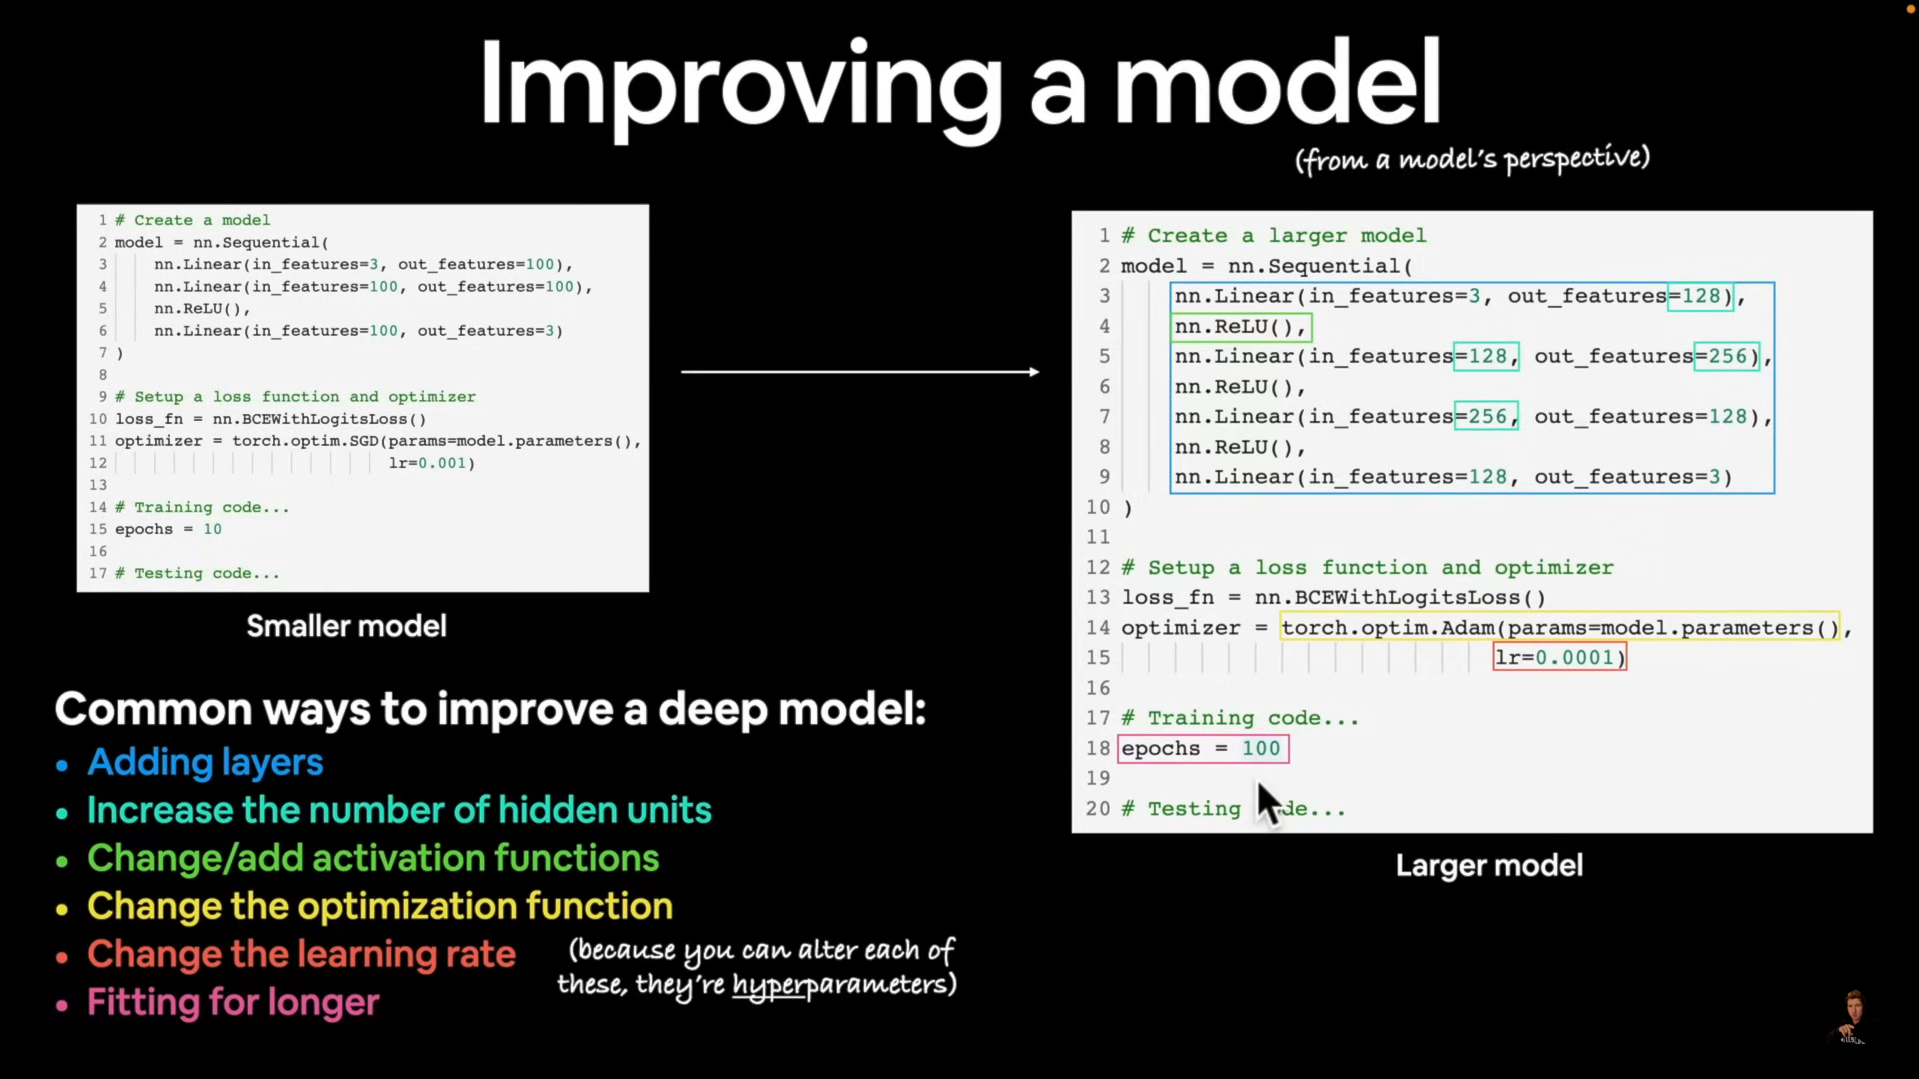